# Using parareal with Partial Differential Equations

Here, we'll apply the parareal scheme to the numerical resolution of a boundary value problem. In particular, we want to solve the linear diffussion differential equation:

$$
\frac{\partial u}{\partial t} + c\frac{\partial u}{\partial x} = 0
$$

with given boundary and initial conditions:

$$
u(0, t) = 0 \\
u(2, t) = 0 \\
u(x, 0) = u_0(x)
$$

In [1]:
#We'll need these libraries
import numpy as np
import matplotlib.pyplot as plt

## Discretization
We'll introduce a grid of step $\Delta t$ in time and $\Delta x$ in space, and a the shorthand $u^n_i \equiv u(i \Delta x, n \Delta t)$. 

In [2]:
## Physical parameters
c = 1

## Numerical parameters

### Domain
start = 0
finish = 2
size = finish - start

### Grid
nx = 200
nt = 70
xs = np.linspace(start, finish, nx)

### Steps
dt = 0.01
dx = size/(nx - 1)

ts = [i * dt for i in range(0, nt)]

It may be useful to store some of this information in dictionaries

In [3]:
phys = {'c' : c }

grid = {'xs' : xs,
        'ts' : ts}

# We don't need to store all of it, as some of the parameters
# can be derived from xs and ts
def read_grid(grid, prompt):
    """ Quick access to grid properties """
    
    xs = grid['xs']
    ts = grid['ts']
    
    if prompt == 'start':
        return xs[0]
    if prompt == 'end':
        return xs[-1]
    if prompt == 'size':
        return xs[-1] - xs[0]
    if prompt == 'nx':
        return len(xs)
    if prompt == 'nt':
        return len(ts)
    if prompt == 'dx':
        return np.diff(xs)[0]
    if prompt == 'dt':
        return np.diff(ts)[0]

The boundary conditions are translated to the numerical grid as:

$$
u^n_0 = 0 \\
u^n_{N-1} = 0 \\
u^0_i = u_0(i \Delta x)
$$

In [4]:
## Initial and boundary conditions

### Set the initial conditions
def ic(x):
    """ Auxiliary function
    to define the initial conditions
    """
    y = .0 * (x < 0.9) + \
        10 * (x - 0.9) * (0.9 <= x) * (x < 1.0) + \
        10 * (1.1 - x) * (1.0 <= x) * (x <= 1.1) + \
        .0 * (1.1 < x)
    
    return y


### Initialize matrix
u = np.empty((nx, nt))

### Store initial conditions
u[:, 0] = ic(xs)

### Store boundary conditions
u[0, :] = 0
u[-1, :] = 0

Using a forward in time, backward in space scheme, the numerical schemes reads as:

$$
\frac{u^{n+1}_i - u^n_i}{\Delta t} + \frac{c}{\Delta x} (u^n_i - u^n_{i-1} ) = 0
$$

or, equivalently, as the explicit iterator:

$$
u^{n+1}_i = u^n_i - \sigma (u^n_i - u^n_{i-1})
$$

Note that the iterator is controlled by the adimensional parameter $\sigma$ defined as:

$$
\sigma \equiv c \frac{\Delta t}{\Delta x}
$$

In [5]:
def sigma(grid, phys):
    """ Calculates sigma for the problem """
    return phys['c'] * read_grid(grid, 'dt') / read_grid(grid, 'dx')

s = sigma(grid, phys)
print(s)

0.995


In [6]:
def scheme(u_this, u_back, sigma):
    """ Given u_this (u here and now) and u_back (u back and now) returns u_future (u here and one step to the future)"""
    
    u_future = u_this - sigma * (u_this - u_back)
    
    return u_future

So far, this is just one of the many classical schemes for solving a partial differential equation. In order to make a link with the parareal method, we need to write a function that updates in time all the spatial coordinates.

This is relativelly straightforward to do using vector notation:

$$
  \begin{align}
     \begin{bmatrix}
        u^{n+1}_0 \\
        u^{n+1}_1 \\
        \vdots \\
        u^{n+1}_i \\
        \vdots \\
        u^{n+1}_{N-2} \\
        u^{n+1}_{N-1}
      \end{bmatrix}
      =
      \begin{bmatrix}
        u^n_0 \\
        u^n_1 - \sigma (u^n_1 - u^n_0) \\
        \vdots \\
        u^n_i - \sigma (u^n_i - u^n_{i-1}) \\
        \vdots \\
        u^{n}_{N-2} - \sigma (u^n_{N-2} - u^n_{N-3}) \\
        u^{n}_{N-1}
      \end{bmatrix}
  \end{align}
$$

That is, we have a function that allows us to update our vector of states $\vec u$ from time $n$ to time $n+1$:

$$
\vec{u}^{n+1} = N(\vec{u}^{n}; \sigma)
$$

In [7]:
def N(u_now, sigma):
    """ Single step update """
    
    # Create the output vector
    nx = len(u_now)
    u_future = np.empty(nx)
    
    # Populate it
    u_future[0] = u_now[0] # Boundary condition
    for i in range(1, nx-1):
        u_future[i] = scheme(u_now[i], u_now[i-1], sigma)
    u_future[-1] = u_now[-1] # Boundary condition
    
    return u_future

We can apply $N$ iterativelly starting from the first column, which is provided by the initial conditions. This allows us to compute any future state at any point.

$$
\vec{u}^{n} = N^{n}(\vec{u}^0, \sigma)
$$

In [8]:
for n in range(0, nt-1):
    u[:, n+1] = N(u[:,n], s)

The results look as expected: the shape of the initial condition just travels with speed $c$ and without distortion.

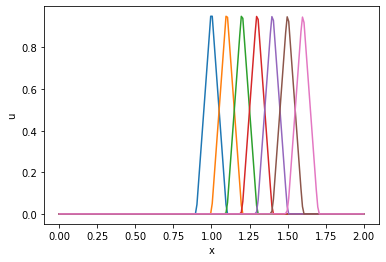

In [9]:
plt.plot(xs, u[:, 0::10])
plt.xlabel('x');
plt.ylabel('u');

## Using time as coordinate

The iterator derived above deals with time through the discrete index $n$. A more practical integrator uses times instead:

$$
\vec u (t) = \Phi(\vec u^0, t_0, t)
$$

We can link both types of integrators using:

$$
\vec u (n \Delta t) = N^n(\vec u^0; \sigma)
$$

In [10]:
def phi(u0, t, grid, phys):
    """ Update in time """
    
    # Extract relevant parameters from grid
    dt = read_grid(grid, 'dt')
    s = sigma(grid, phys)
    
    # Find nearest n
    n = int(np.floor(t/dt))
    
    # Apply the discrete integrator n times
    u_aux = u0
    for i in range(0, n):
        u_aux = N(u_aux, s)
        
    return u_aux

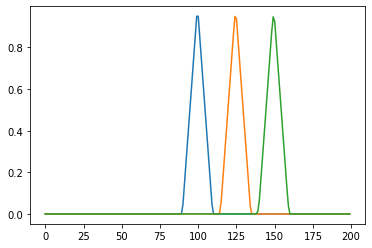

In [11]:
plt.plot(phi(u[:, 0], 0.00, grid, phys));
plt.plot(phi(u[:, 0], 0.25, grid, phys));
plt.plot(phi(u[:, 0], 0.50, grid, phys));

# Building the coarse and the fine integrator

A straightforward way of writing a coarse and a fine integrator is to use two instances of $\Phi$ with a coarse and a fine grid.

In [12]:
# Fine grid
xs_f = np.arange(0, 2.0, 0.01)
ts_f = np.arange(0, 0.7, 0.01)
grid_f = {'xs' : xs_f,
          'ts' : ts_f}

# Coarse grid (causes numerical dispersion)
xs_g = np.arange(xs_f[0], xs_f[-1], 0.01)
ts_g = np.arange(ts_f[0], ts_f[-1], 0.005)
grid_g = {'xs' : xs_g,
          'ts' : ts_g}

def F(u0, t):
    """ Fine integrator """
    return phi(u0, t, grid_f, phys)

def G(u0, t):
    """ Coarse integrator (with numerical dispersion) """
    return phi(u0, t, grid_g, phys)

By using those integrators, we see that while the fine integrator $F$ works decently, the coarse integrator $G$ shows numerical dispersion:

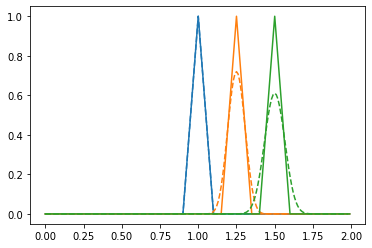

In [13]:
# Initialize
u0_f = ic(xs_f)
u0_g = ic(xs_g)

plt.plot(xs_f, u0_f, 'C0')
plt.plot(xs_g, u0_g, 'C0', linestyle='--')
plt.plot(xs_f, F(u0_f, 0.25), 'C1', );
plt.plot(xs_g, G(u0_g, 0.25), 'C1', linestyle='--');
plt.plot(xs_f, F(u0_f, 0.5), 'C2');
plt.plot(xs_g, G(u0_g, 0.5), 'C2', linestyle='--');

In [14]:
# Work in progress...